In [1]:
import uuid
from enum import Enum

In [2]:
from glob import glob
from pathlib import Path
from joblib import Parallel, delayed

In [3]:
import numpy as np
import pandas as pd
import datasets

In [4]:
from tqdm import tqdm

In [5]:
from prettytable import PrettyTable

In [6]:
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import sklearn

from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

In [8]:
base_path = './data/ecg_final'

In [9]:
participants = [Path(path).stem for path in glob(f'{base_path}/*.csv')]
train_participants, test_participants = train_test_split(participants, test_size=0.2, random_state=42)

In [10]:
def encode(baseline = 0, mental_stress = -1, high_physical_activity = -1, moderate_physical_activity = -1, low_physical_activity = -1):
    def inner(labels):
        baseline_list = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
        mental_stress_list = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
        high_physical_stress_list = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
        moderate_physical_stress_list = ['Walking_own_pace', 'Dishes', 'Vacuum']
        low_physical_stress_list = ['Standing', 'Lying_supine', 'Recov_standing']
        
        def encode_multiclass(label):
            if label in baseline_list:
                return baseline
            elif label in mental_stress_list:
                return mental_stress
            elif label in high_physical_stress_list:
                return high_physical_activity
            elif label in moderate_physical_stress_list:
                return moderate_physical_activity
            elif label in low_physical_stress_list:
                return low_physical_activity
            else:
                return -1
            
        return {
            'label': [encode_multiclass(label) for label in labels],
        }
    return inner

def clean(dataset, mapping={}):
    dataset = dataset.map(
        encode(**mapping), 
        batched=True, 
        batch_size=2048, 
        input_columns=['label'],
        num_proc=4
    )
    return dataset.filter(
        lambda label: label != -1,
        input_columns=['label'],
    )


In [11]:
class Model(Enum):
    DecisionTree = 1
    RandomForest = 2 
    AdaBoost = 3
    LinearDiscriminantAnalysis = 4
    KNearestNeighbors = 5
    LogisticRegression = 6
    XGBoost = 7
    QuadraticDiscriminantAnalysis = 8
    DummyClassifier = 9

In [12]:
X_labels =  [
    "hrv_mean",
    "hrv_min",
    "hrv_max",
    "hrv_std",
    "hrv_rms",
    "hr_max",
    "rr_mean",
    "rr_min",
    "rr_max",
    "rr_std",
    "nn50",
    "pnn50",
    "rmssd",
    "MeanNN",
    "SDNN",
    "SDANN1",
    "SDNNI1",
    "SDANN2",
    "SDNNI2",
    "SDANN5",
    "SDNNI5",
    "RMSSD",
    "SDSD",
    "CVNN",
    "CVSD",
    "MedianNN",
    "MadNN",
    "MCVNN",
    "IQRNN",
    "SDRMSSD",
    "Prc20NN",
    "Prc80NN",
    "pNN50",
    "pNN20",
    "MinNN",
    "MaxNN",
    "HTI",
    "TINN",
    "twa",

    # new
    'vhf_entropy',  # 0.28
    'lp_vhf_entropy', # 0.28
    'lp_vhf_max',   # 0.25
    'vhf_max',   # 0.25
    'lp_vhf_mean',   # 0.24
    'lp_vhf_std',   # 0.24
    'lp_vhf_energy', # 0.22
    'lp_vhf_power', # 0.22
    'lp_vhf_median',      # 0.21
    'vhf_std',      # 0.21
    'vhf_power',    # 0.21
    'vhf_mean',    # 0.21
    'tp_entropy',   # 0.21
    'vhf_median', # 0.19
    'lp_vhf_covariance', # 0.17
    'lp_lf_min', # 0.17
    'w',            # 0.17
    'PSS',          # 0.17
    'wmax',         # 0.16
    'hr_min',       # 0.16
    'lp_uhf_entropy', # 0.16
    'wen',          # 0.15
    'hr_mean',      # 0.15
    'PIP',          # 0.15
    'hf_entropy',   # 0.15
    'uhf_entropy',  # 0.14
    'IALS',         # 0.14
    'FuzzyEn',      # 0.14
    'SampEn',       # 0.13
]
y_label = 'label'

In [13]:
def train(model:int, train_indices, val_indices, params, mapping = {}):
    dataset = datasets.load_dataset(
        f'{base_path}', 
        train_participants=[train_participants[i] for i in train_indices],
        val_participants=[train_participants[i] for i in val_indices],
        test_participants=test_participants,
        trust_remote_code=True
    )

    dataset = dataset.select_columns([y_label] + X_labels)
    dataset = clean(dataset, mapping=mapping)
    
    train = dataset['fit'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)

    X_train, y_train = train[X_labels], train[y_label]
    del train

    if model == 1:
        cls = DecisionTreeClassifier( **params, random_state=42)
    elif model == 2:
        cls = RandomForestClassifier(**params, random_state=42, bootstrap=False)
    elif model == 3:
        cls = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', min_samples_split=20), **params)
    elif model == 4:
        cls = LinearDiscriminantAnalysis(**params)
    elif model == 5:
        cls = KNeighborsClassifier(**params)
    elif model == 6:
        cls = LogisticRegression(**params)
    elif model == 7:
        cls = XGBClassifier(**params)
    elif model == 8:
        cls = QuadraticDiscriminantAnalysis(**params)
    elif model == 9:
        cls = sklearn.dummy.DummyClassifier(**params)
    else: 
        raise ValueError('Invalid model')

    cls.fit(X_train, y_train)

    del X_train

    val = dataset['validate'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)
    X_val, y_val = val[X_labels], val[y_label]
    del val

    test = dataset['test'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)
    X_test, y_test = test[X_labels], test[y_label]
    del test

    data = {
        'val_accuracy': sklearn.metrics.accuracy_score(y_val, cls.predict(X_val)),
        'val_balanced_accuracy': sklearn.metrics.balanced_accuracy_score(y_val, cls.predict(X_val)),
        'test_accuracy': sklearn.metrics.accuracy_score(y_test, cls.predict(X_test)),
        'test_balanced_accuracy': sklearn.metrics.balanced_accuracy_score(y_test, cls.predict(X_test)),
    }

    if len(y_train.unique()) == 2:
        ## binary
        data['val_f1'] = sklearn.metrics.f1_score(y_val, cls.predict(X_val))
        data['test_f1'] = sklearn.metrics.f1_score(y_test, cls.predict(X_test))

        # AUC
        data['val_auc'] = sklearn.metrics.roc_auc_score(y_val, cls.predict_proba(X_val)[:, 1])
        data['test_auc'] = sklearn.metrics.roc_auc_score(y_test, cls.predict_proba(X_test)[:, 1])
        
        # Confusion Matrix
        val_cm = sklearn.metrics.confusion_matrix(y_val, cls.predict(X_val), labels=y_train.unique())
        test_cm = sklearn.metrics.confusion_matrix(y_test, cls.predict(X_test), labels=y_train.unique())

        data['val_cm'] = val_cm
        data['test_cm'] = test_cm
    else: 
        # multiclass
        data['val_f1'] = sklearn.metrics.f1_score(y_val, cls.predict(X_val), average='micro')
        data['test_f1'] = sklearn.metrics.f1_score(y_test, cls.predict(X_test), average='micro')

        # AUC (one-vs-rest)
        y_val_bin = sklearn.preprocessing.label_binarize(y_val, classes=np.unique(y_train))
        y_test_bin = sklearn.preprocessing.label_binarize(y_test, classes=np.unique(y_train))
        
        val_auc = sklearn.metrics.roc_auc_score(y_val_bin, cls.predict_proba(X_val), average='macro', multi_class='ovr')
        test_auc = sklearn.metrics.roc_auc_score(y_test_bin, cls.predict_proba(X_test), average='macro', multi_class='ovr')
        
        data['val_auc'] = val_auc
        data['test_auc'] = test_auc
        
        # Confusion Matrix
        val_cm = sklearn.metrics.confusion_matrix(y_val, cls.predict(X_val), labels=y_train.unique())
        test_cm = sklearn.metrics.confusion_matrix(y_test, cls.predict(X_test), labels=y_train.unique())

        data['val_cm'] = val_cm
        data['test_cm'] = test_cm

    del y_train, X_val, y_val
    
    if model == 2:
        importances = cls.feature_importances_
        feature_importance = pd.DataFrame(importances, index=X_labels, columns=["importance"])
        feature_importance["std"] = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)
        feature_importance.sort_values(by='importance', ascending=False, inplace=True)

        result = permutation_importance(
            cls, X_test, y_test, n_repeats=10, random_state=42
        )
        permutation_importances = pd.DataFrame(result.importances_mean, index=X_labels, columns=["importance"])
        permutation_importances["std"] = result.importances_std
        permutation_importances.sort_values(by='importance', ascending=False, inplace=True)

        data['feature_importance'] = feature_importance["importance"].head(5)
        data['fi_std'] = feature_importance["std"].head(5)
        data['permutation_importances'] = permutation_importances["importance"].head(5)
        data['pi_std'] = permutation_importances["std"].head(5)

    del X_test, y_test

    return data 

In [14]:
def optimize(model: Model, k_fold=5, mapping={}, best_params=None):
    skip_optimization = best_params is not None

    table = PrettyTable()
    table.title = f'{model.name}'
    table.field_names = [
        '',
        'Validation F1', 
        'Test F1', 
        'Validation Accuracy', 
        'Test Accuracy', 
        'Validation Balanced Accuracy', 
        'Test Balanced Accuracy',
        'Validation AUC',
        'Test AUC'
    ]
    model_value = int(model.value)

    def objective(trial):
        if model == Model.DecisionTree:
            params = {
                'max_depth': trial.suggest_int('max_depth', 1, 32),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            }
        elif model == Model.RandomForest:
            params = {
                "n_estimators": 500,
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "min_samples_split": trial.suggest_int("min_samples_split", 10, 200, step=10),
                "max_features": trial.suggest_int("max_features", 3, 15),
            }
        elif model == Model.AdaBoost:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
            }
        elif model == Model.LinearDiscriminantAnalysis:
            params = {
                'solver': trial.suggest_categorical('solver', ['lsqr', 'eigen']),
                'shrinkage': trial.suggest_uniform('shrinkage', 0.0, 1.0),
            }
        elif model == Model.KNearestNeighbors:
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'p': trial.suggest_int('p', 1, 2),
            }
        elif model == Model.LogisticRegression:
            params = {
                'C': trial.suggest_loguniform('C', 1e-5, 1e5),
                'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
                'max_iter': trial.suggest_int('max_iter', 100, 1000),
            }
        elif model == Model.XGBoost:
            params = {
                'max_depth': trial.suggest_int('max_depth', 1, 16),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                'n_estimators': trial.suggest_int('n_estimators', 10, 300),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            }
        elif model == Model.QuadraticDiscriminantAnalysis:
            params = {
                'reg_param': trial.suggest_uniform('reg_param', 0.0, 1.0),
            }
        else: 
            raise ValueError('Invalid model')

        scores = Parallel(n_jobs=1)(delayed(train)(model_value, train_indices, val_indices, params, mapping=mapping) for train_indices, val_indices in KFold(n_splits=k_fold, shuffle=True, random_state=42).split(train_participants)) 
        df = pd.DataFrame(scores)
        return np.mean([df['test_auc'].mean(), df['test_auc'].median()])

    def detailed(trial): 
        if isinstance(trial, optuna.Trial):
            if model == Model.DecisionTree:
                params = {
                    'max_depth': trial.suggest_int('max_depth', 1, 32),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                }
            elif model == Model.RandomForest:
                params = {
                    "n_estimators": 500,
                    "max_depth": trial.suggest_int("max_depth", 2, 10),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 200, step=10),
                    "max_features": trial.suggest_int("max_features", 3, 15),
                }
            elif model == Model.AdaBoost:
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                }
            elif model == Model.LinearDiscriminantAnalysis:
                params = {
                    'solver': trial.suggest_categorical('solver', ['lsqr', 'eigen']),
                    'shrinkage': trial.suggest_uniform('shrinkage', 0.0, 1.0),
                }
            elif model == Model.KNearestNeighbors:
                params = {
                    'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
                    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                    'p': trial.suggest_int('p', 1, 2),
                }
            elif model == Model.LogisticRegression:
                params = {
                    'C': trial.suggest_loguniform('C', 1e-5, 1e5),
                    'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
                    'max_iter': trial.suggest_int('max_iter', 100, 1000),
                }
            elif model == Model.XGBoost:
                params = {
                    'max_depth': trial.suggest_int('max_depth', 1, 16),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                    'n_estimators': trial.suggest_int('n_estimators', 10, 300),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
                }
            elif model == Model.QuadraticDiscriminantAnalysis:
                params = {
                    'reg_param': trial.suggest_uniform('reg_param', 0.0, 1.0),
                }
            elif model == Model.DummyClassifier:
                params = {}
            else: 
                raise ValueError('Invalid model')
        else:
            params = trial
        
        data = Parallel(n_jobs=1)(delayed(train)(model_value, train_indices, val_indices, params, mapping=mapping) for train_indices, val_indices in KFold(n_splits=k_fold, shuffle=True, random_state=42).split(train_participants)) 
        return pd.DataFrame(data)

    if skip_optimization == False:
        study = optuna.create_study(
            study_name=f'{model.name}_{base_path}_{str(uuid.uuid4())}',
            storage="sqlite:///db.sqlite3",
            direction='maximize',
            sampler=optuna.samplers.RandomSampler(seed=42)
        )

        study.optimize(
            objective, 
            n_trials=5,
            show_progress_bar=True
        )
    
        # Get the best hyperparameters
        best_params = study.best_params
        best_score = study.best_value

        print("Best Score:", best_score)
        print("Best Parameters:", best_params)

    if skip_optimization:
        print("Skipping optimization, using given parameters...", best_params)
        df = detailed(best_params)
    else:
        df = detailed(study.best_trial)

    titles = []
    if ("baseline" not in mapping) or (mapping["baseline"] != -1):
        titles.append("Baseline")
    if "mental_stress" in mapping and mapping["mental_stress"] >= 0:
        titles.append("Mental Stress")
    if "low_physical_activity" in mapping and mapping["low_physical_activity"] >= 0:
        titles.append("Low Physical Activity")
    if "moderate_physical_activity" in mapping and mapping["moderate_physical_activity"] >= 0:
        titles.append("Moderate Physical Activity")
    if "high_physical_activity" in mapping and mapping["high_physical_activity"] >= 0:
        titles.append("High Physical Activity")
        
    row = [
        f"{' & '.join(titles)}",
        f"{round(df['val_f1'].mean() * 100, 2)}% ± {round(df['val_f1'].std() * 100, 2)}%", 
        f"{round(df['test_f1'].mean() * 100, 2)}% ± {round(df['test_f1'].std() * 100, 2)}%", 
        f"{round(df['val_accuracy'].mean() * 100, 2)}% ± {round(df['val_accuracy'].std() * 100, 2)}%", 
        f"{round(df['test_accuracy'].mean() * 100, 2)}% ± {round(df['test_accuracy'].std() * 100, 2)}%", 
        f"{round(df['val_balanced_accuracy'].mean() * 100, 2)}% ± {round(df['val_balanced_accuracy'].std() * 100, 2)}%", 
        f"{round(df['test_balanced_accuracy'].mean() * 100, 2)}% ± {round(df['test_balanced_accuracy'].std() * 100, 2)}%",
        f"{round(df['val_auc'].mean() * 100, 2)}% ± {round(df['val_auc'].std() * 100, 2)}%", 
        f"{round(df['test_auc'].mean() * 100, 2)}% ± {round(df['test_auc'].std() * 100, 2)}%"
    ]
    table.add_row(row)

    print(table)
    
    print("Validation Confusion Matrix")
    for arr in df['val_cm']:
        print('[')
        for val in arr:
            print(val)
        print(']')
    
    print("Test Confusion Matrix")
    for arr in df['test_cm']:
        print('[')
        for val in arr:
            print(val)
        print(']')

    if model == Model.RandomForest:
        first = df.iloc[0]

        fig, ax = plt.subplots()
        first['feature_importance'].plot.barh(yerr=first['fi_std'], ax=ax)
        ax.set_title("Mean Decrease Impurity (MDI)", fontweight='bold')
        ax.set_xlabel("Mean decrease in impurity", fontweight='bold')
        ax.set_ylabel("Features", fontweight='bold')
        fig.tight_layout()
        plt.show()

        fig, ax = plt.subplots()
        first['permutation_importances'].plot.barh(yerr=first['pi_std'], ax=ax)
        ax.set_title("Feature Permutation", fontweight='bold')
        ax.set_xlabel("Mean accuracy decrease", fontweight='bold')
        ax.set_ylabel("Features", fontweight='bold')
        fig.tight_layout()
        plt.show()
            
    if skip_optimization == False:
        return study.best_params
    else:
        return best_params

In [15]:
model = Model.DummyClassifier
print("RANDOM GUESSING")

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params={'strategy': 'uniform', 'random_state': 42})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

RANDOM GUESSING
Starting optimization for DummyClassifier (variant = Mental Stress)
Reusing best params for DummyClassifier (variant = Mental Stress & High Physical Activity)
Skipping optimization, using given parameters... {'strategy': 'uniform', 'random_state': 42}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            DummyClassifier                                                                                            |
+----------------------------------------+----------------+---------------+---------------------+---------------+------------------------------+------------------------+----------------+--------------+
|                                        | Validation F1  |    Test F1    | Validation Accuracy | Test Accuracy | Validation B

{'strategy': 'uniform', 'random_state': 42}

In [16]:
model = Model.DummyClassifier
print("SOPHISTICATED GUESSING")

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params={'strategy': 'stratified', 'random_state': 42})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

SOPHISTICATED GUESSING
Starting optimization for DummyClassifier (variant = Mental Stress)
Skipping optimization, using given parameters... {'strategy': 'stratified', 'random_state': 42}


In [15]:
model = Model.DecisionTree

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params={'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 15})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

Starting optimization for DecisionTree (variant = Mental Stress)
Skipping optimization, using given parameters... {'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 15}


Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                        DecisionTree                                                                                        |
+--------------------------+---------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                          | Validation F1 |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC    |
+--------------------------+---------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
| Baseline & Mental Stress | 63.88% ± 1.1% | 

Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                             DecisionTree                                                                                            |
+-----------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+---------------+
|                                   | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC   |
+-----------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+---------------+


Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                               DecisionTree                                                                                               |
+---------------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                                       | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC    |
+---------------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------

Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                             DecisionTree                                                                                            |
+----------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                                  | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC    |
+----------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+


Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                DecisionTree                                                                                               |
+----------------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                                        | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC    |
+----------------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+-----

Map (num_proc=4):   0%|          | 0/1899905 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/511868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/511868 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1919576 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/492197 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1919576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/492197 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1961914 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/449859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1961914 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/449859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1941816 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/469957 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1941816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/469957 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1923881 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/641272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/487892 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1923881 [00:00<?, ? examples/s]

Filter:   0%|          | 0/641272 [00:00<?, ? examples/s]

Filter:   0%|          | 0/487892 [00:00<?, ? examples/s]

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                    DecisionTree                                                                                                   |
+---------------------------------------------------+----------------+---------------+---------------------+---------------+------------------------------+------------------------+----------------+---------------+
|                                                   | Validation F1  |    Test F1    | Validation Accuracy | Test Accuracy | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC   |
+---------------------------------------------------+----------------+---------------+---------------------+---------------+--------------------

{'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 15}

Starting optimization for RandomForest (variant = Mental Stress)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                        RandomForest                                                                                       |
+--------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+--------------+
|                          | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |   Test AUC   |
+--------------------------+----------------+----------------+---

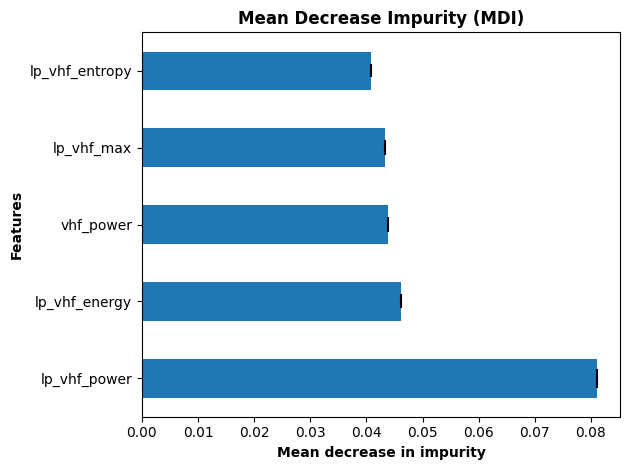

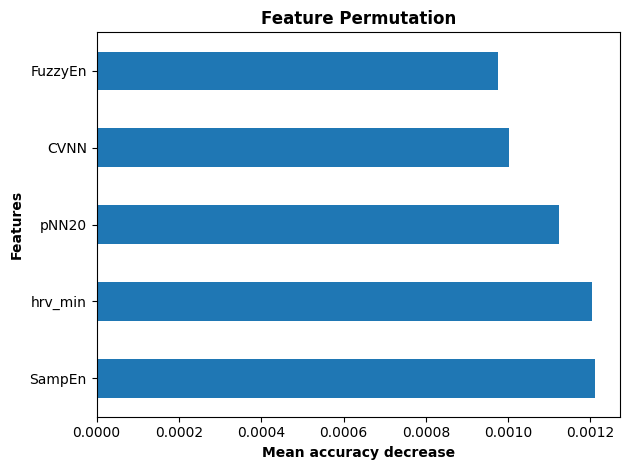

Reusing best params for RandomForest (variant = High Physical Activity)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            RandomForest                                                                                            |
+-----------------------------------+---------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+---------------+
|                                   | Validation F1 |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC   |
+---------------------

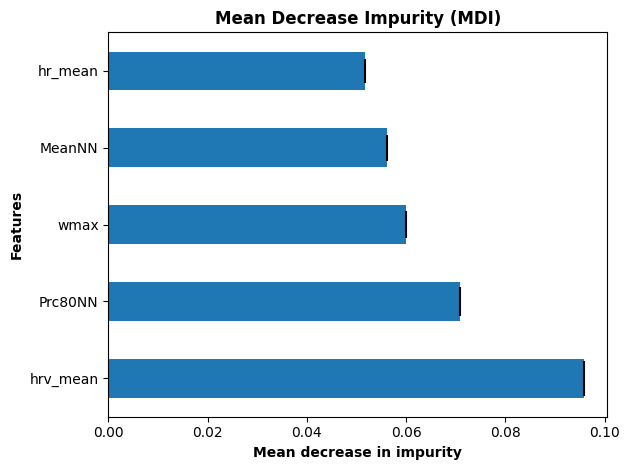

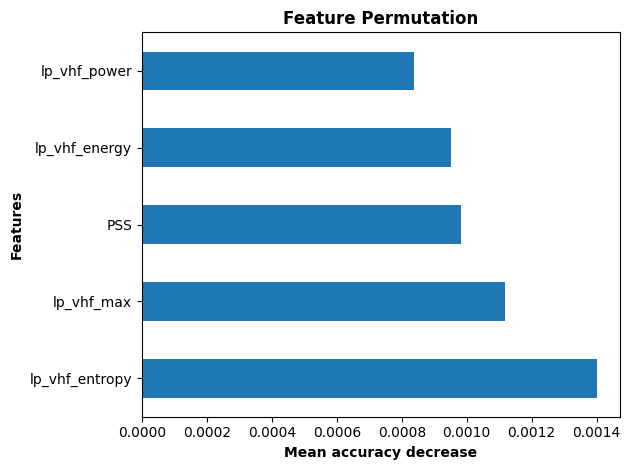

Reusing best params for RandomForest (variant = Moderate Physical Activity)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                               RandomForest                                                                                              |
+---------------------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+---------------+
|                                       | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC   

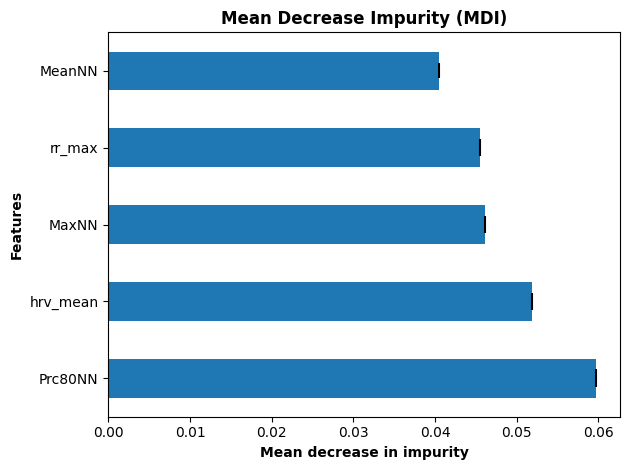

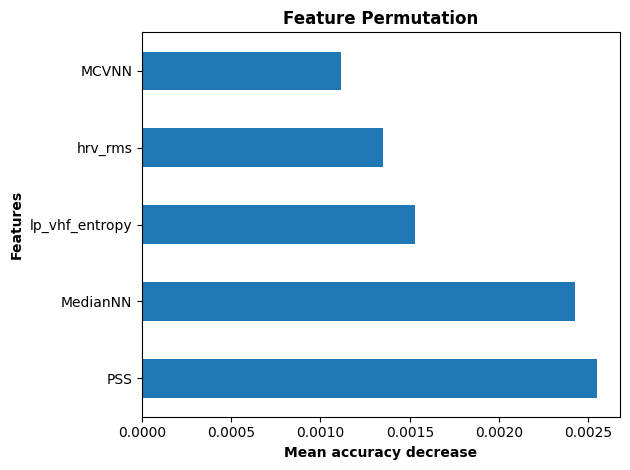

Reusing best params for RandomForest (variant = Low Physical Activity)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            RandomForest                                                                                           |
+----------------------------------+----------------+----------------+---------------------+---------------+------------------------------+------------------------+----------------+---------------+
|                                  | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC   |
+--------------------------

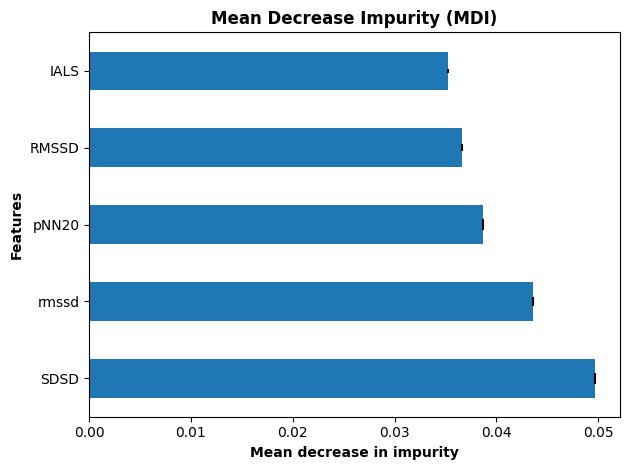

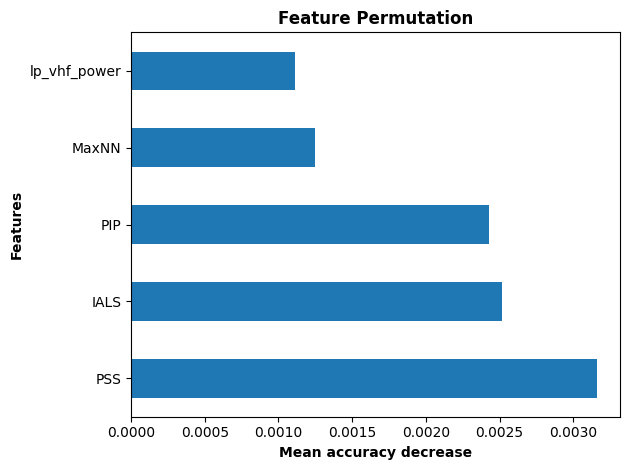

Reusing best params for RandomForest (variant = Mental Stress & High Physical Activity)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                               RandomForest                                                                                               |
+----------------------------------------+---------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                                        | Validation F1 |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |

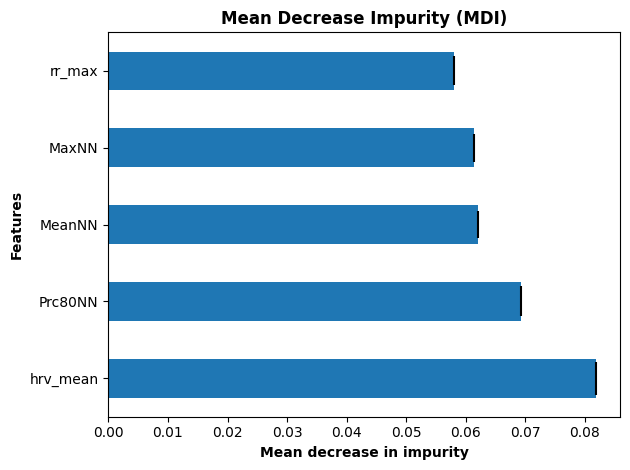

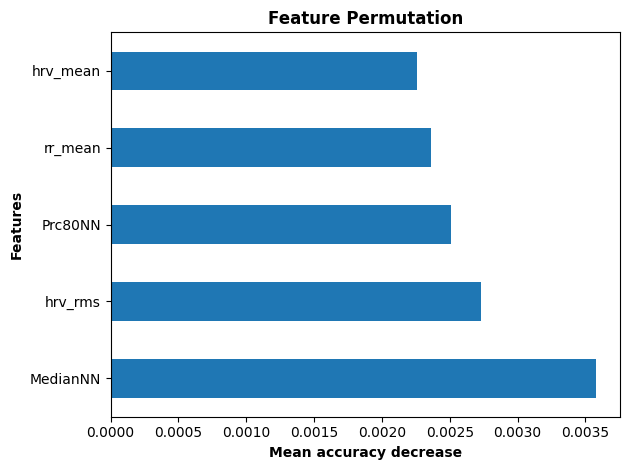

Reusing best params for RandomForest (variant = Baseline & Mental Stress & High Physical Activity)
Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                     RandomForest                                                                                                    |
+---------------------------------------------------+---------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                                                   | Validation F1 |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanc

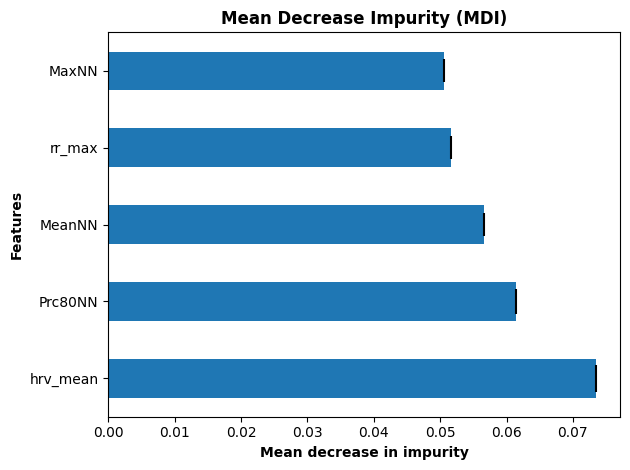

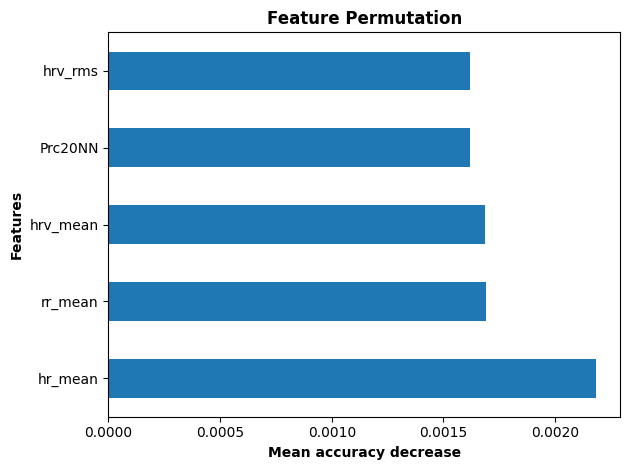

{'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}

In [16]:
model = Model.RandomForest

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params={'max_depth': 8, 'min_samples_split': 50, 'max_features': 5})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

In [16]:
model = Model.AdaBoost

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params={'n_estimators': 100})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

Starting optimization for AdaBoost (variant = Mental Stress)
Skipping optimization, using given parameters... {'n_estimators': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [19]:
model = Model.LinearDiscriminantAnalysis

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, best_params= {})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

Starting optimization for LinearDiscriminantAnalysis (variant = Mental Stress)
Skipping optimization, using given parameters... {'solver': 'lsqr', 'shrinkage': 0.15599452033620265}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                  LinearDiscriminantAnalysis                                                                                 |
+--------------------------+----------------+----------------+---------------------+----------------+------------------------------+------------------------+----------------+----------------+
|                          | Validation F1  |    Test F1     | Validation Accuracy | Test Accuracy  | Validation Balanced Accuracy | Test Balanced Accuracy | Validation AUC |    Test AUC    |
+--------------------------+----------------+------

{'solver': 'lsqr', 'shrinkage': 0.15599452033620265}

In [ ]:
model = Model.KNearestNeighbors

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 }, params={'n_neighbors': 9})

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

[I 2024-07-25 18:32:43,945] A new study created in RDB with name: KNearestNeighbors_./data/ecg_final_453bf7d8-1958-44e2-836e-556470cd7170


Starting optimization for KNearestNeighbors (variant = Mental Stress)


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-07-26 00:30:55,047] Trial 0 finished with value: 0.5762645504240577 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.5762645504240577.


In [ ]:
model = Model.LogisticRegression

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 })

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "lower_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

In [ ]:
model = Model.XGBoost

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 })

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)

In [ ]:
model = Model.QuadraticDiscriminantAnalysis

print("Starting optimization for", model.name, "(variant = Mental Stress)")
best_params = optimize(model, mapping={ "mental_stress": 1 })

print("Reusing best params for", model.name, "(variant = High Physical Activity)")
optimize(model, mapping={ "high_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Moderate Physical Activity)")
# optimize(model, mapping={ "moderate_physical_activity": 1 }, best_params=best_params)
# print("Reusing best params for", model.name, "(variant = Low Physical Activity)")
# optimize(model, mapping={ "low_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Mental Stress & High Physical Activity)")
optimize(model, mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 }, best_params=best_params)
print("Reusing best params for", model.name, "(variant = Baseline & Mental Stress & High Physical Activity)")
optimize(model, mapping={ "mental_stress": 1, "high_physical_activity": 2 }, best_params=best_params)